<a href="https://colab.research.google.com/github/bkn872/GL_Guru_Nov22/blob/ET/SA_heart_disease%2B_281_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context:
A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal. 

# Problem Statement:
For the given attributes of a patient classify if the patient is suffering from heart disease or not

# Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Import data

In [3]:
df = pd.read_csv('/content/drive/My Drive/20_GRP4_Nov22A/06_FMT/W1_FE/Mentor/saheart.dat',sep = ',', header = 13, names = ['Sbp', 'Tobacco', 'Ldl', 'Adiposity',
                                                                'Famhist', 'Typea', 'Obesity', 'Alcohol', 'Age', 'Chd'])

In [4]:
df.head()

,Sbp,Tobacco,Ldl,Adiposity,Famhist,Typea,Obesity,Alcohol,Age,Chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


# Brief Exploration of the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sbp        462 non-null    int64  
 1   Tobacco    462 non-null    float64
 2   Ldl        462 non-null    float64
 3   Adiposity  462 non-null    float64
 4   Famhist    462 non-null    object 
 5   Typea      462 non-null    int64  
 6   Obesity    462 non-null    float64
 7   Alcohol    462 non-null    float64
 8   Age        462 non-null    int64  
 9   Chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


- There are no null values in the data
- One of the features is object type, which we will have to encode

In [6]:
df.Chd.value_counts()

0    302
1    160
Name: Chd, dtype: int64

- The data is quiet imbalanced but would not consider it as highly imbalanced
- We will anyway up-sample the minority class

In [7]:
df.Famhist.replace(['Absent', 'Present'], [0,1], inplace = True)  # manually encoding the strings

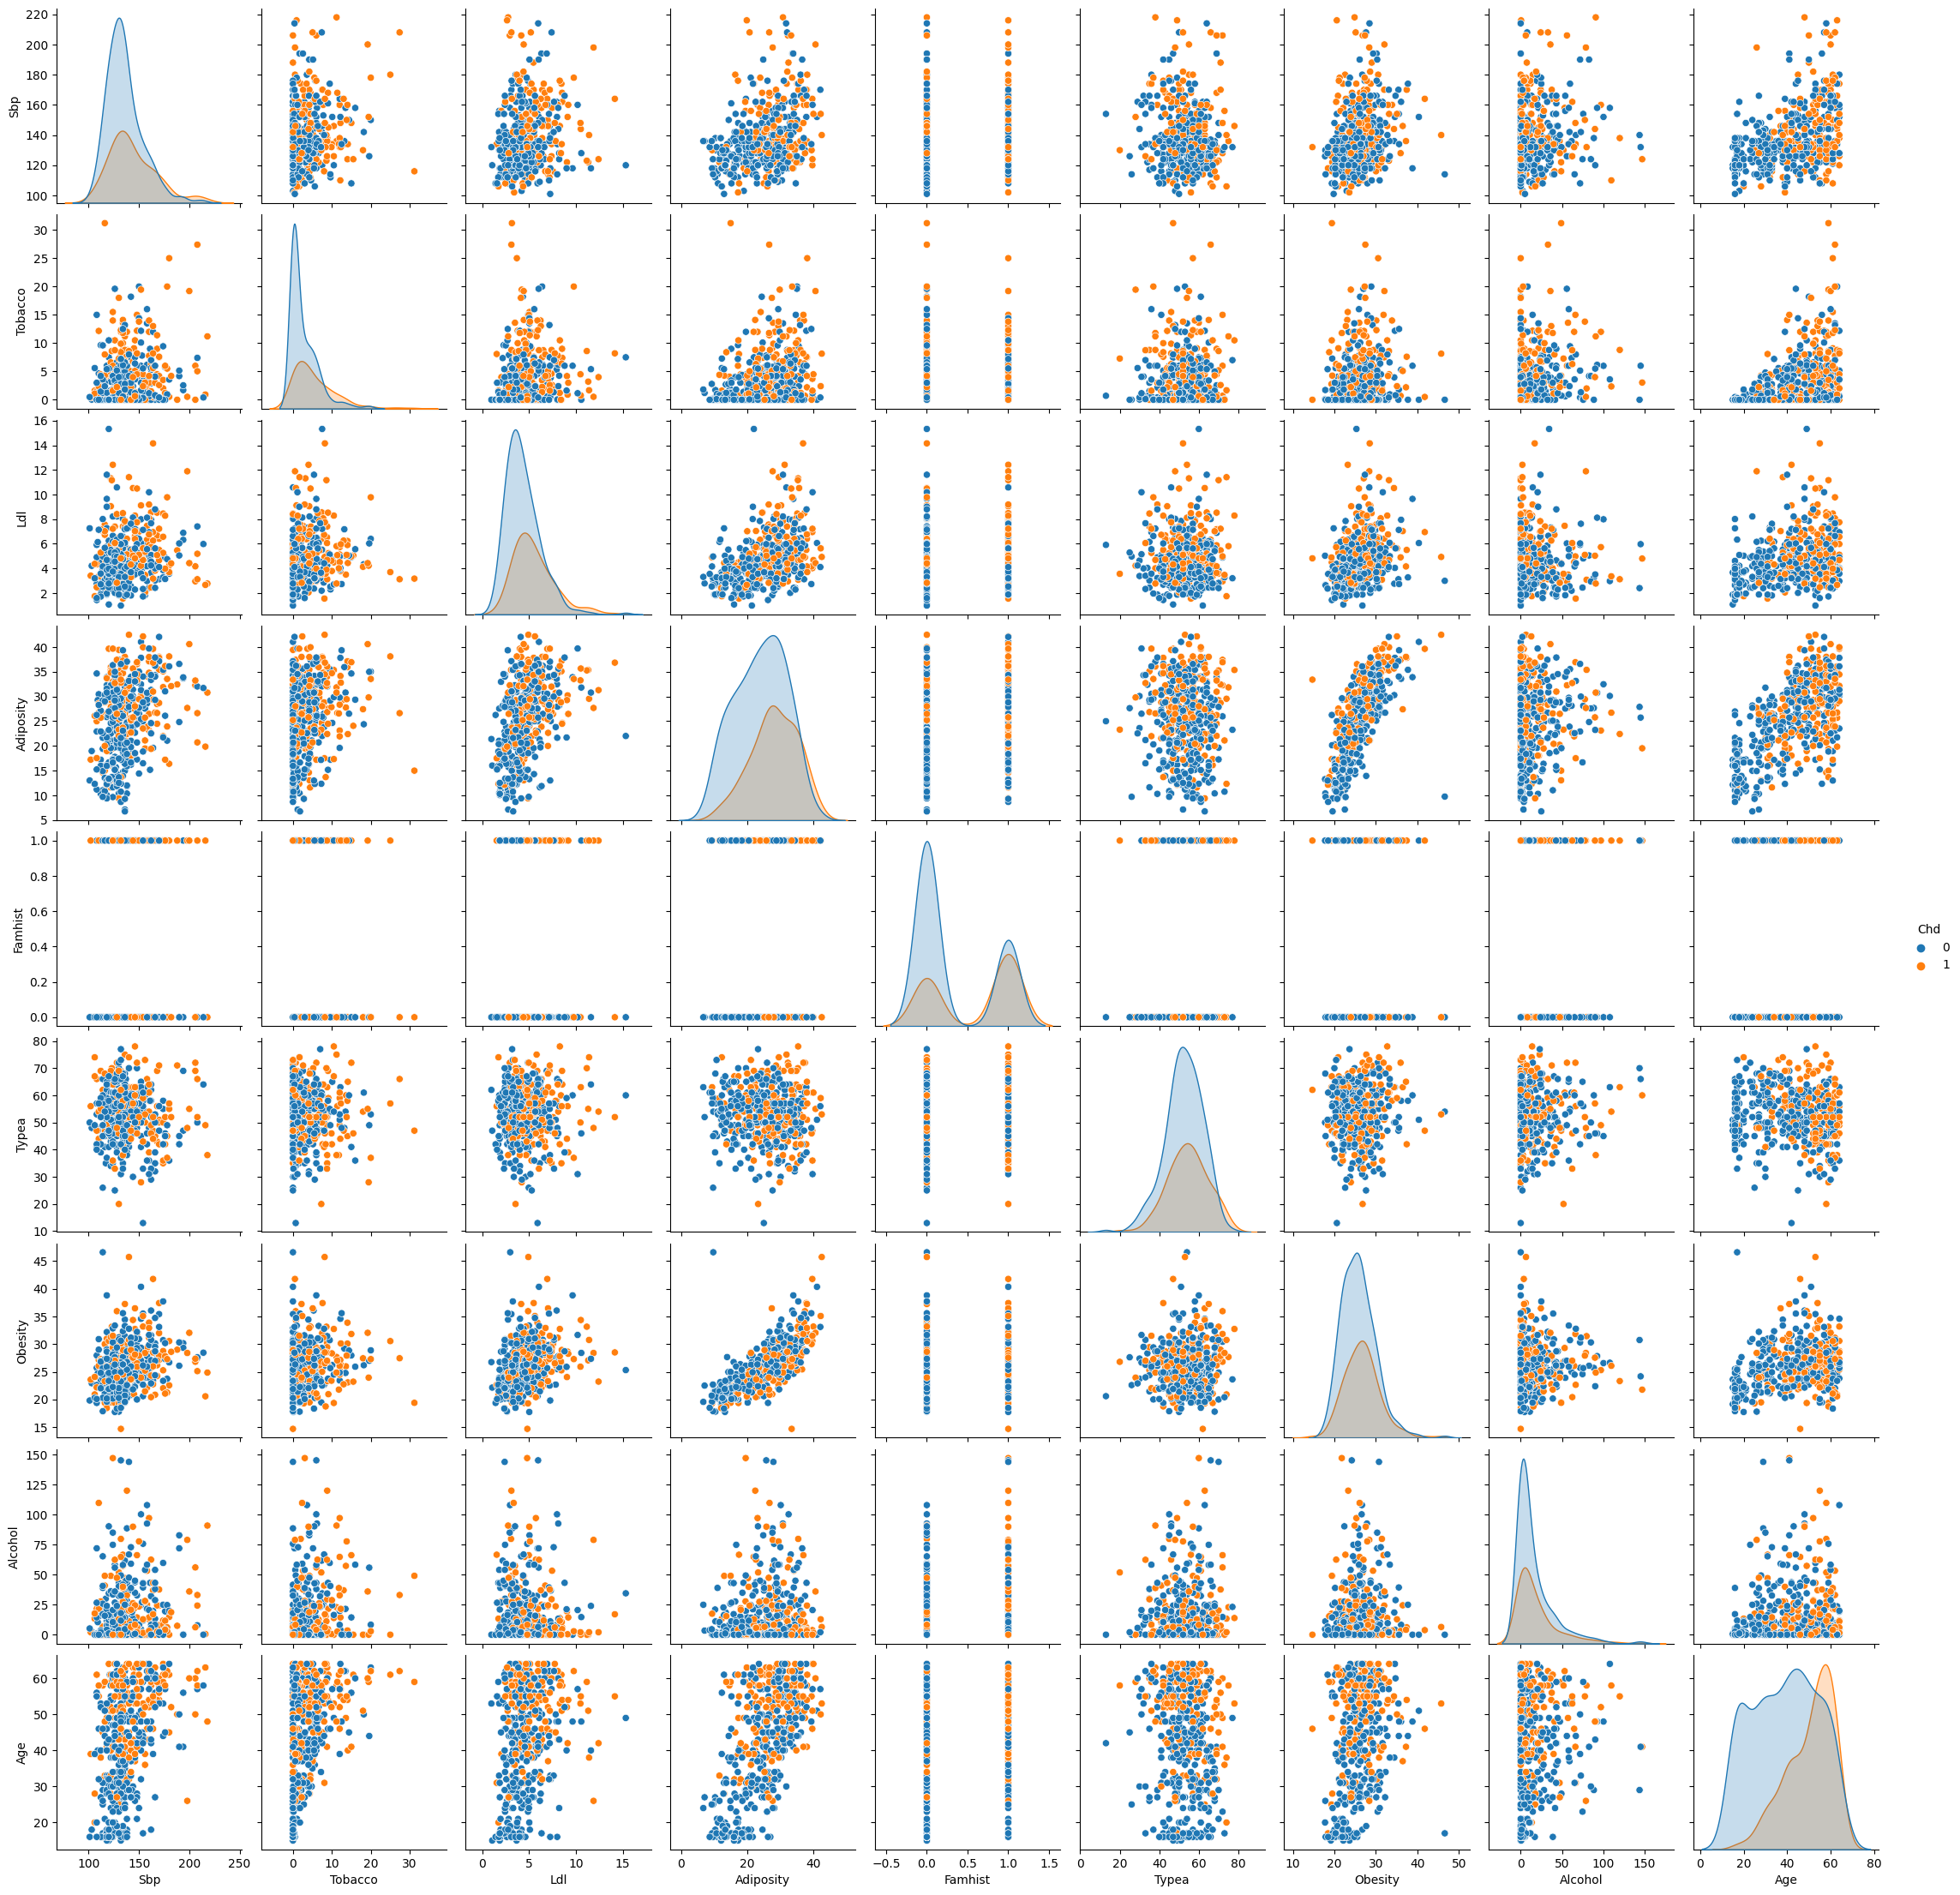

In [8]:
sns.pairplot(df, diag_kind= 'kde', hue = 'Chd')
plt.show()

- Age seems to be a good predictor of Chd
- There is some amout of correlation between Obesity and Adiposity

In [9]:
X = df.drop(columns= ['Chd', 'Obesity'])
y = df.Chd

Disclaimer: Before deciding to drop 'Obesity', we have gone through a couple of iterations of model building and dropping obesity resulted in better predictions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((346, 8), (116, 8), (346,), (116,))

In [11]:
extra_samples = df[df['Chd'] == 1].drop(columns = 'Obesity').sample(n = 60, random_state = 1)
X_train = pd.concat([X_train, extra_samples.drop(columns='Chd')])
y_train = pd.concat([y_train, extra_samples.Chd])

In [12]:
# sm = SMOTE(sampling_strategy= 'minority', random_state= 1 )

# X_train, y_train = sm.fit_resample(X_train, y_train)

- The cell before the one above is simple upsampling where we are duplicating the records
- In the subsequent cell, we have tried to use SMOTE to upsample
- The former gave us better results in this case

# Train and evaluate models
### Logistic Regression

In [13]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [14]:
lr_score = logreg.score(X_test, y_test)
print(f"Score : {lr_score}")

Score : 0.7327586206896551


In [15]:
pred = logreg.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()

In [16]:
lr_recall = round(tp/(tp+fn), 3)   # Of all the people with Chd, how many were recognised to have Chd
lr_precision = round(tp/(tp+fp), 3)  # Of all the people predicted to have Chd, how many did have Chd
lr_specificity =round(tn/(tn+fp),3)    # Of all the people without Chds, how many were recognised to not have Chd
type_1_error = fp    # People without Chd predicted to have Chd
type_2_error = fn    # People with Chd predicted to have no Chd

In [17]:
lr_recall, lr_precision, lr_specificity, type_1_error, type_2_error

(0.65, 0.605, 0.776, 17, 14)

AUC: 0.779


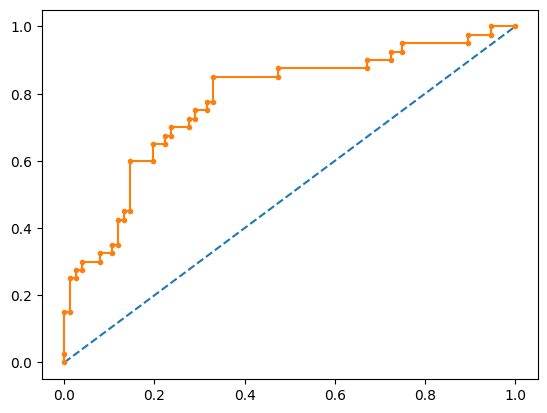

In [18]:
probs = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Decision Tree

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

dt_score = dt.score(X_test, y_test)
print(f"Score : {dt_score}")

pred = dt.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()

Score : 0.7155172413793104


In [20]:
dt_recall = round(tp/(tp+fn), 3)   
dt_precision = round(tp/(tp+fp), 3)  
dt_specificity =round(tn/(tn+fp),3) 
dt_type_1_error = fp   
dt_type_2_error = fn  

In [21]:
dt_recall, dt_precision, dt_specificity, dt_type_1_error, dt_type_2_error

(0.7, 0.571, 0.724, 21, 12)

AUC: 0.712


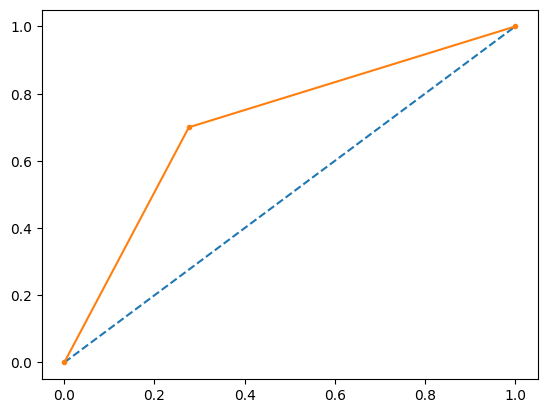

In [22]:
probs = dt.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf.fit(X_train, y_train)

rf_score = rf.score(X_test, y_test)
print(f"Score : {rf_score}")

pred = rf.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()

Score : 0.7672413793103449


In [24]:
rf_recall = round(tp/(tp+fn), 3)   
rf_precision = round(tp/(tp+fp), 3)  
rf_specificity =round(tn/(tn+fp),3) 
rf_type_1_error = fp   
rf_type_2_error = fn 

In [25]:
rf_recall, rf_precision, rf_specificity, rf_type_1_error, rf_type_2_error

(0.6, 0.686, 0.855, 11, 16)

AUC: 0.821


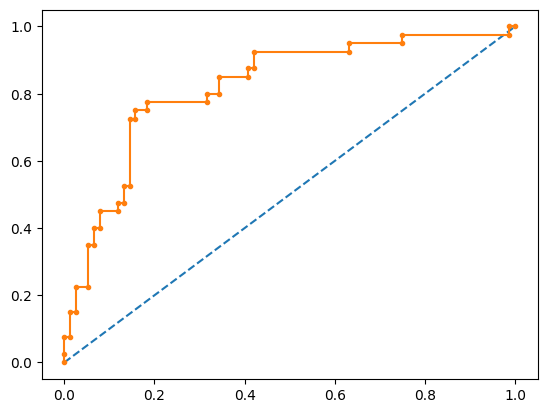

In [26]:
probs = rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Adaboost

In [27]:
ac = AdaBoostClassifier()
ac.fit(X_train, y_train)

ac_score = ac.score(X_test, y_test)
print(f"Score : {ac_score}")

pred = ac.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()

Score : 0.7068965517241379


In [28]:
ac_recall = round(tp/(tp+fn), 3)   
ac_precision = round(tp/(tp+fp), 3)  
ac_specificity =round(tn/(tn+fp),3) 
ac_type_1_error = fp   
ac_type_2_error = fn 

ac_recall, ac_precision, ac_specificity, ac_type_1_error, ac_type_2_error

(0.675, 0.562, 0.724, 21, 13)

AUC: 0.774


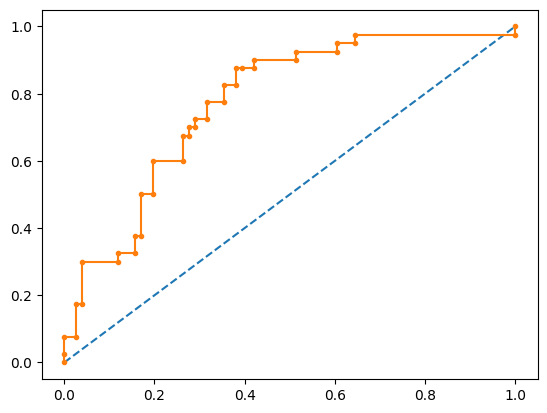

In [29]:
probs = ac.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### Gradient Boost

In [30]:
gc = GradientBoostingClassifier()
gc.fit(X_train, y_train)

gc_score = gc.score(X_test, y_test)
print(f"Score : {gc_score}")

pred = gc.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test,pred).ravel()

Score : 0.7758620689655172


In [31]:
gc_recall = round(tp/(tp+fn), 3)   
gc_precision = round(tp/(tp+fp), 3)  
gc_specificity =round(tn/(tn+fp),3) 
gc_type_1_error = fp   
gc_type_2_error = fn 

gc_recall, gc_precision, gc_specificity, gc_type_1_error, gc_type_2_error

(0.7, 0.667, 0.816, 14, 12)

AUC: 0.801


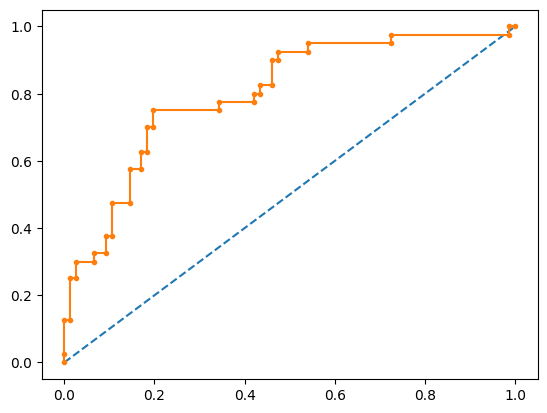

In [32]:
probs = gc.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

# Result

In [33]:
metric = np.array([[lr_recall, lr_precision, lr_specificity],
 [dt_recall, dt_precision, dt_specificity],
 [rf_recall, rf_precision, rf_specificity],
 [ac_recall, ac_precision, ac_specificity],
 [gc_recall, gc_precision, gc_specificity]]).T
 
metric

array([[0.65 , 0.7  , 0.6  , 0.675, 0.7  ],
       [0.605, 0.571, 0.686, 0.562, 0.667],
       [0.776, 0.724, 0.855, 0.724, 0.816]])

In [34]:
result = pd.DataFrame({'Model' : ['Logistic Regression', 'DecisionTree', 'Random Forest', 'Ada boost', "Gradient boost'"], 
                       'Accuracy' : [lr_score, dt_score, rf_score, ac_score, gc_score],
                      'Recall' : metric[0],
                      'Precision' : metric[1],
                      'Specificity' : metric[2]})
result

,Model,Accuracy,Recall,Precision,Specificity
0,Logistic Regression,0.732759,0.650,0.605,0.776
1,DecisionTree,0.715517,0.700,0.571,0.724
2,Random Forest,0.767241,0.600,0.686,0.855
3,Ada boost,0.706897,0.675,0.562,0.724
4,Gradient boost',0.775862,0.700,0.667,0.816


what worked:
* Dropping obesity - We have also seen that there was a good amount of correlation between Adiposity and Obesity
* Over sampling - Class imbalance was an essential part since our target column was highly imbalanced and we could not let the algorithms be biased against minority class